### Hybrid method: Add collaborative filtering to current LightGBM model

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# 1. Load & preprocess trainer static data
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
trainers = pd.read_csv(pt_path)
for c in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[c] = pd.to_numeric(trainers[c], errors='coerce').fillna(0)

# Fit separate log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))

trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()

# Scale other numeric features independently
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()

# Compute a static PCA score
pca_cols = [
    'total_likes_norm','videos_count_norm',
    'workout_recommendations_norm','athlete_rating_norm','years_experience_norm'
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[pca_cols].dot(w)

trainers['specialities'] = trainers['specialities'].astype(str)


# 2. Load synthetic interactions and merge in static_score + specialities
hist_path = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
df = pd.read_csv(hist_path)
df = df.merge(
    trainers[['trainer_id','static_score','specialities']],
    on='trainer_id', how='left'
)


# 3. Compute collaborative filtering score per (user,trainer) based on KNN
# build user×trainer pivot of labels
pivot = df.pivot_table(
    index='user_id',
    columns='trainer_id',
    values='label',
    fill_value=0
)
user_ids    = pivot.index.tolist()
trainer_ids = pivot.columns.tolist()
R = csr_matrix(pivot.values)
# fit kNN on user vectors
nn = NearestNeighbors(n_neighbors=10, metric='cosine').fit(R)
# for each user, find neighbors and aggregate their labels
cf_score_dict = {}
distances, neighbors = nn.kneighbors(R, return_distance=True)
for ui, u in enumerate(user_ids):
    nbrs = neighbors[ui]
    # exclude self if present
    nbrs = [n for n in nbrs if n != ui]
    nbr_users = [user_ids[n] for n in nbrs]
    nbr_df = df[df['user_id'].isin(nbr_users)]
    mean_by_tr = nbr_df.groupby('trainer_id')['label'].mean().to_dict()
    cf_score_dict[u] = mean_by_tr
# map CF scores back into df
df['cf_score'] = df.apply(
    lambda r: cf_score_dict.get(r['user_id'], {}).get(r['trainer_id'], 0.0),
    axis=1
)


# 4. Helper functions for dynamic features
def tokenize(text):
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

def compute_overlap(goals, specs):
    G = tokenize(goals); S = tokenize(specs)
    I = G & S; U = G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))


# 5. Compute other dynamic features
df = df.reset_index(drop=True)
ov = df.apply(lambda r: compute_overlap(r['user_goals'], r['specialities']), axis=1)
df['overlap_count']   = [t[0] for t in ov]
df['jaccard_score']   = [t[1] for t in ov]
df['direction_match'] = [t[2] for t in ov]

# Fix history-watch logic: cumulative per user
df = df.sort_values(['user_id']).reset_index(drop=True)
df['watch_hist_cnt'] = (
    df.groupby('user_id')['watched_count']
      .apply(lambda s: s.shift().fillna(0).cumsum())
      .reset_index(level=0, drop=True)
)


# 6. Re‑apply count‑feature scaling
df['total_likes']  = scaler_likes.transform(np.log1p(df[['total_likes']])).ravel()
df['videos_count'] = scaler_videos.transform(np.log1p(df[['videos_count']])).ravel()

# 7. Filter out users with no positive labels
valid_users = df.groupby('user_id')['label'].max().loc[lambda x: x>0].index
df = df[df['user_id'].isin(valid_users)].reset_index(drop=True)

# 8. Define features, label & grouping
feature_cols = [
    'watch_hist_cnt',
    'athlete_rating','total_likes','videos_count',
    'workout_recommendations','years_experience',
    'static_score',
    # collaborative filtering feature
    'cf_score'
]
label_col = 'label'
group_col = 'user_id'

def make_group(dd):
    return dd.groupby(group_col).size().tolist()


# 9. 5‑fold GroupKFold CV + LambdaRank
gkf = GroupKFold(n_splits=5)
ndcg_at = [5, 10, 15]
fold_ndcg = {k: [] for k in ndcg_at}
fold_map  = []

for train_idx, val_idx in gkf.split(df, groups=df[group_col]):
    tr = df.iloc[train_idx].reset_index(drop=True)
    va = df.iloc[val_idx].reset_index(drop=True)

    dtr = lgb.Dataset(tr[feature_cols], label=tr[label_col], group=make_group(tr))
    dva = lgb.Dataset(va[feature_cols], label=va[label_col],
                      group=make_group(va), reference=dtr)

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': ndcg_at,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 50,
        'verbose': -1
    }

    model = lgb.train(
        params,
        dtr,
        num_boost_round=500,
        valid_sets=[dva],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    va['pred'] = model.predict(va[feature_cols])

    # NDCG
    for k in ndcg_at:
        scs = []
        for _, grp in va.groupby(group_col):
            y_t = grp[label_col].values.reshape(1, -1)
            y_p = grp['pred'].values.reshape(1, -1)
            if y_t.size > 1:
                scs.append(ndcg_score(y_t, y_p, k=k))
        fold_ndcg[k].append(np.mean(scs))

    # MAP
    maps = []
    for _, grp in va.groupby(group_col):
        y_bin = (grp[label_col] > 0).astype(int)
        if y_bin.sum() > 0:
            maps.append(average_precision_score(y_bin, grp['pred'].values))
    fold_map.append(np.mean(maps) if maps else 0.0)

# 10. Print CV results
for k in ndcg_at:
    print(f"CV NDCG@{k}: {np.mean(fold_ndcg[k]):.4f} ± {np.std(fold_ndcg[k]):.4f}")
print(f"CV MAP: {np.mean(fold_map):.4f} ± {np.std(fold_map):.4f}")

# 11. Train final model on all data & save
dall = lgb.Dataset(df[feature_cols], label=df[label_col], group=make_group(df))
final_model = lgb.train(params, dall, num_boost_round=model.best_iteration)
final_model.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_with_cf.txt")


Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.886063	valid_0's ndcg@10: 0.886712	valid_0's ndcg@15: 0.914556
Early stopping, best iteration is:
[20]	valid_0's ndcg@5: 0.88717	valid_0's ndcg@10: 0.88517	valid_0's ndcg@15: 0.914238
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.893994	valid_0's ndcg@10: 0.889616	valid_0's ndcg@15: 0.917452
[100]	valid_0's ndcg@5: 0.893892	valid_0's ndcg@10: 0.89004	valid_0's ndcg@15: 0.917674
Early stopping, best iteration is:
[84]	valid_0's ndcg@5: 0.894505	valid_0's ndcg@10: 0.890506	valid_0's ndcg@15: 0.918617
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.890211	valid_0's ndcg@10: 0.886651	valid_0's ndcg@15: 0.913255
[100]	valid_0's ndcg@5: 0.891989	valid_0's ndcg@10: 0.887354	valid_0's ndcg@15: 0.914735
[150]	valid_0's ndcg@5: 0.892322	valid_0's ndcg@10: 0.888867	valid_0's ndcg@15: 0.915874
[200]	valid_0's ndcg@5: 0.891575	valid_0's 

### SHAP evaluation script for a LightGBM ranking model with collaborative filtering feature


In [6]:
import os
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score, average_precision_score

# paths to your data and model
TRAINER_DATA_PATH = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
INTERACTIONS_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
FINAL_MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_with_cf.txt"
SHAP_OUTPUT_DIR   = "/Users/cailingchen/Desktop/Final Project/Model/shap_output"

os.makedirs(SHAP_OUTPUT_DIR, exist_ok=True)

# load trainer static data
trainers = pd.read_csv(TRAINER_DATA_PATH)

# convert columns to numeric and fill missing values
for col in ["athlete_rating", "total_likes", "videos_count", "workout_recommendations", "years_experience"]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)

# fit log1p + MinMaxScaler on total_likes and videos_count
likes_scaler  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
videos_scaler = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

trainers["total_likes_norm"]  = likes_scaler.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = videos_scaler.transform(np.log1p(trainers[["videos_count"]])).ravel()

# normalize other numeric features independently
for col in ["workout_recommendations", "athlete_rating", "years_experience"]:
    trainers[f"{col}_norm"] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# compute a single static_score via PCA
pca_features = [
    "total_likes_norm",
    "videos_count_norm",
    "workout_recommendations_norm",
    "athlete_rating_norm",
    "years_experience_norm"
]
pca = PCA(n_components=1).fit(trainers[pca_features])
weights = np.abs(pca.components_[0])
weights /= weights.sum()
trainers["static_score"] = trainers[pca_features].dot(weights)

trainers["specialities"] = trainers["specialities"].astype(str)

# load user-trainer interactions and merge static_score
df = pd.read_csv(INTERACTIONS_PATH)
df = df.merge(
    trainers[["trainer_id", "static_score", "specialities"]],
    on="trainer_id",
    how="left"
)

# build user×trainer matrix and fit NearestNeighbors
pivot = df.pivot_table(index="user_id", columns="trainer_id", values="label", fill_value=0)
R = csr_matrix(pivot.values)
nn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(R)
_, neighbors = nn.kneighbors(R, return_distance=True)

# compute collaborative filtering score per (user, trainer)
cf_dict = {}
user_list = pivot.index.tolist()
for ui, user in enumerate(user_list):
    nbrs = [n for n in neighbors[ui] if n != ui]
    nbr_users = [user_list[n] for n in nbrs]
    subset = df[df["user_id"].isin(nbr_users)]
    mean_scores = subset.groupby("trainer_id")["label"].mean().to_dict()
    cf_dict[user] = mean_scores

df["cf_score"] = df.apply(
    lambda row: cf_dict.get(row["user_id"], {}).get(row["trainer_id"], 0.0),
    axis=1
)

# define tokenizer and overlap functions
def tokenize(text):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals, specs):
    G = tokenize(goals)
    S = tokenize(specs)
    intersect = G & S
    union = G | S
    return len(intersect), (len(intersect) / len(union) if union else 0.0), int(bool(intersect))

# compute goal-speciality overlap features
overlap_vals = df.apply(lambda row: compute_overlap(row["user_goals"], row["specialities"]), axis=1)
df["overlap_count"]   = [v[0] for v in overlap_vals]
df["jaccard_score"]   = [v[1] for v in overlap_vals]
df["direction_match"] = [v[2] for v in overlap_vals]

# compute cumulative watch history count per user
df = df.sort_values("user_id").reset_index(drop=True)
df["watch_hist_cnt"] = (
    df.groupby("user_id")["watched_count"]
      .apply(lambda s: s.shift().fillna(0).cumsum())
      .reset_index(level=0, drop=True)
)

# normalize interaction-side static features again
df["total_likes"]  = likes_scaler.transform(np.log1p(df[["total_likes"]])).ravel()
df["videos_count"] = videos_scaler.transform(np.log1p(df[["videos_count"]])).ravel()

# filter out users with no positive labels
valid_users = df.groupby("user_id")["label"].max().loc[lambda x: x > 0].index
df = df[df["user_id"].isin(valid_users)].reset_index(drop=True)

# prepare feature matrix and label
feature_columns = [
    "watch_hist_cnt",
    "athlete_rating",
    "total_likes",
    "videos_count",
    "workout_recommendations",
    "years_experience",
    "static_score",
    "cf_score"
]

missing = set(feature_columns) - set(df.columns)
if missing:
    raise ValueError(f"Missing features: {missing}")

X      = df[feature_columns]
y      = df["label"]
groups = df["user_id"]

# perform GroupKFold cross‑validation with LambdaRank
gkf = GroupKFold(n_splits=5)
ndcg_results = {5: [], 10: [], 15: []}
map_results  = []

params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5, 10, 15],
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 50,
    "verbose": -1
}

for train_idx, valid_idx in gkf.split(X, y, groups):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    group_train = df.iloc[train_idx].groupby("user_id").size().tolist()
    group_valid = df.iloc[valid_idx].groupby("user_id").size().tolist()

    dtrain = lgb.Dataset(X_train, label=y_train, group=group_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, group=group_valid, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=500,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )

    preds = model.predict(X_valid)
    df_valid = df.iloc[valid_idx].copy()
    df_valid["pred"] = preds

    for k in [5, 10, 15]:
        scores = [
            ndcg_score([grp["label"].values], [grp["pred"].values], k=k)
            for _, grp in df_valid.groupby("user_id") if len(grp) > 1
        ]
        ndcg_results[k].append(np.mean(scores))

    ap_scores = [
        average_precision_score((grp["label"] > 0).astype(int), grp["pred"].values)
        for _, grp in df_valid.groupby("user_id") if grp["label"].max() > 0
    ]
    map_results.append(np.mean(ap_scores))

for k in [5, 10, 15]:
    print(f"NDCG@{k}: {np.mean(ndcg_results[k]):.4f} ± {np.std(ndcg_results[k]):.4f}")
print(f"MAP: {np.mean(map_results):.4f} ± {np.std(map_results):.4f}")

# train final model on all data and save
group_all = df.groupby("user_id").size().tolist()
dall = lgb.Dataset(X, label=y, group=group_all)
final_model = lgb.train(params, dall, num_boost_round=model.best_iteration)
final_model.save_model(FINAL_MODEL_PATH)

# run SHAP evaluation on the final model
explainer = shap.TreeExplainer(final_model, feature_perturbation="interventional")
sample    = X.sample(n=5000, random_state=42)
shap_vals = explainer.shap_values(sample)

shap.summary_plot(shap_vals, sample, show=False)
plt.tight_layout()
plt.savefig(os.path.join(SHAP_OUTPUT_DIR, "summary_scatter.png"))
plt.clf()

shap.summary_plot(shap_vals, sample, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(os.path.join(SHAP_OUTPUT_DIR, "summary_bar.png"))
plt.clf()

shap.dependence_plot("cf_score", shap_vals, sample, show=False)
plt.tight_layout()
plt.savefig(os.path.join(SHAP_OUTPUT_DIR, "dependence_cf_score.png"))
plt.clf()

# create and save interactive force plot (HTML)
force_viz = shap.plots.force(
    explainer.expected_value,
    shap_vals[0],
    sample.iloc[0]
)
shap.save_html(os.path.join(SHAP_OUTPUT_DIR, "force_plot.html"), force_viz)

# save feature importance table
importance_df = pd.DataFrame({
    "feature": sample.columns,
    "mean_abs_shap": np.abs(shap_vals).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)
importance_df.to_csv(os.path.join(SHAP_OUTPUT_DIR, "feature_importance.csv"), index=False)
print(importance_df)


Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.886063	valid_0's ndcg@10: 0.886712	valid_0's ndcg@15: 0.914556
Early stopping, best iteration is:
[20]	valid_0's ndcg@5: 0.88717	valid_0's ndcg@10: 0.88517	valid_0's ndcg@15: 0.914238
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.893994	valid_0's ndcg@10: 0.889616	valid_0's ndcg@15: 0.917452
[100]	valid_0's ndcg@5: 0.893892	valid_0's ndcg@10: 0.89004	valid_0's ndcg@15: 0.917674
Early stopping, best iteration is:
[84]	valid_0's ndcg@5: 0.894505	valid_0's ndcg@10: 0.890506	valid_0's ndcg@15: 0.918617
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.890211	valid_0's ndcg@10: 0.886651	valid_0's ndcg@15: 0.913255
[100]	valid_0's ndcg@5: 0.891989	valid_0's ndcg@10: 0.887354	valid_0's ndcg@15: 0.914735
[150]	valid_0's ndcg@5: 0.892322	valid_0's ndcg@10: 0.888867	valid_0's ndcg@15: 0.915874
[200]	valid_0's ndcg@5: 0.891575	valid_0's 

/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


                   feature  mean_abs_shap
7                 cf_score       0.769699
0           watch_hist_cnt       0.124442
6             static_score       0.029292
5         years_experience       0.006007
3             videos_count       0.005194
2              total_likes       0.003533
4  workout_recommendations       0.003100
1           athlete_rating       0.002500


<Figure size 800x470 with 0 Axes>

<Figure size 750x500 with 0 Axes>

In [17]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import lightgbm as lgb

# Paths and parameters
PT_PATH     = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_with_cf.txt"
OUTPUT_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_cf.csv"
TOP_K       = 18
VIDEO_NUM   = 5
ALPHA       = 0.05
P_MAX       = 0.95

# Helper functions
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), len(I)/len(U) if U else 0.0, int(bool(I))

def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated:
        return score_given if score_given >= 3 else 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1

# 1. Load & preprocess trainer data
trainers = pd.read_csv(PT_PATH)
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)
trainers['specialities'] = trainers['specialities'].astype(str)

# 2. Compute static_score via PCA
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()
dims = ['total_likes_norm','videos_count_norm','workout_recommendations_norm','athlete_rating_norm','years_experience_norm']
pca = PCA(n_components=1).fit(trainers[dims])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[dims].dot(w)

# 3. Load history & model
history_df = pd.read_csv(HIST_PATH)
ranker     = lgb.Booster(model_file=MODEL_PATH)

# 4. One-shot Top-K recommendation per user with CF feature placeholder
feature_cols = ['watch_hist_cnt','athlete_rating','total_likes','videos_count',
                'workout_recommendations','years_experience','static_score','cf_score']
first_list = []
for user_id, ev in history_df.groupby('user_id', sort=False):
    ev = ev.reset_index(drop=True)
    goals = ev.at[0,'user_goals']
    pool = trainers.copy()
    # dynamic watch history
    watch_map = ev.groupby('trainer_id')['watched_count'].sum().to_dict()
    pool['watch_hist_cnt'] = pool['trainer_id'].map(watch_map).fillna(0).astype(int)
    # overlap features
    ov = pool['specialities'].apply(lambda s: compute_overlap(goals, s))
    pool['overlap_count'], pool['jaccard_score'], pool['direction_match'] = zip(*ov)
    # re-scale counts
    pool['total_likes']  = scaler_likes.transform(np.log1p(pool[['total_likes']])).ravel()
    pool['videos_count'] = scaler_videos.transform(np.log1p(pool[['videos_count']])).ravel()
    # CF placeholder
    pool['cf_score'] = 0.0
    # model prediction + normalization
    pool['pred_score'] = ranker.predict(pool[feature_cols].values)
    pool['pred_norm']  = MinMaxScaler().fit_transform(pool[['pred_score']]).ravel()
    pool['dir_norm']   = MinMaxScaler().fit_transform(pool[['direction_match']]).ravel()
    # composite score
    pool['composite_score'] = 0.8 * pool['pred_norm'] + 0.2 * pool['dir_norm']
    # select Top-K
    topk = pool.nlargest(TOP_K, 'composite_score')[['trainer_id']].copy()
    topk['user_id'] = user_id
    first_list.append(topk)
first_df = pd.concat(first_list, ignore_index=True)

# 5. Simulate second-round interactions based on recommendations
second_records = []
for user_id, recs in first_df.groupby('user_id', sort=False):
    user_hist = history_df[history_df['user_id'] == user_id]
    goals = user_hist['user_goals'].iloc[0]
    for _, rec in recs.iterrows():
        tid = rec['trainer_id']
        # overlap
        spec = trainers.loc[trainers['trainer_id']==tid, 'specialities'].iloc[0]
        ov_count, ov_jac, ov_dir = compute_overlap(goals, spec)
        # watch simulation
        base_prob = min(0.2 + 0.2*ov_count, P_MAX)
        watch_sum, flags = 0, []
        for _ in range(VIDEO_NUM):
            p = min(base_prob + ALPHA*watch_sum, P_MAX)
            w = int(random.random() < p)
            flags.append(w); watch_sum += w
        # rating simulation
        if watch_sum >= 2:
            rated = int(random.random() < min(0.1+0.15*watch_sum+0.4*ov_jac, P_MAX))
        else:
            rated = 0
        score_given = int(np.clip(round(np.random.normal(2.5+0.3*watch_sum+1.5*ov_jac,1.2)),1,5)) if rated else 0
        # label
        label = construct_label(watch_sum, rated, score_given)
        rec_dict = {
            'user_id': user_id,
            'trainer_id': tid,
            'watched_count': watch_sum,
            'rated': rated,
            'score_given': score_given,
            'overlap_count': ov_count,
            'jaccard_score': ov_jac,
            'direction_match': ov_dir,
            'label': label
        }
        for i, w in enumerate(flags, 1): rec_dict[f'watch_v{i}'] = w
        second_records.append(rec_dict)
second_df = pd.DataFrame(second_records)
second_df.to_csv(OUTPUT_PATH, index=False)


Label Distribution Comparison:
       After cold start recommendation  After second round recommendation
label                                                                    
0                                27382                              24980
1                                31457                              30104
2                                18361                              18665
3                                 5099                               5971
4                                 4259                               5404
5                                 3442                               4876


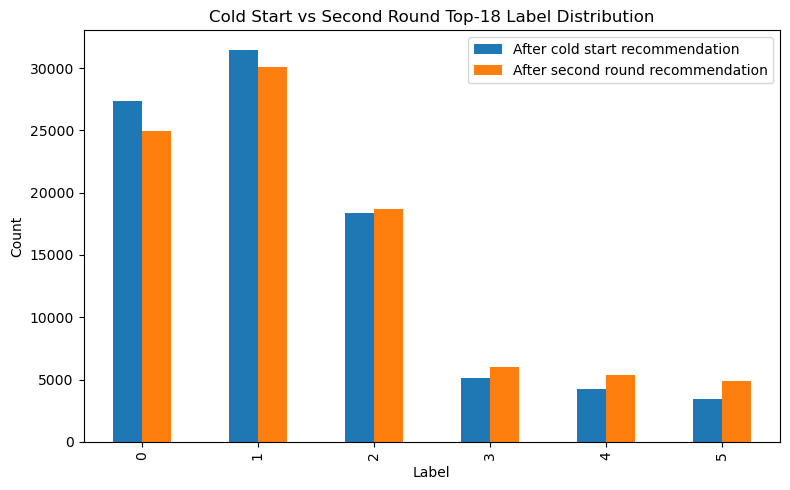

In [18]:
# Label distribution comparison
import pandas as pd
import matplotlib.pyplot as plt

HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
history_df = pd.read_csv(HIST_PATH)

SECOND_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_cf.csv"
second_round = pd.read_csv(SECOND_PATH)

orig = history_df['label'].value_counts().sort_index()
new  = second_round['label'].value_counts().sort_index()
df_cmp = pd.DataFrame({'After cold start recommendation':orig,'After second round recommendation':new}).fillna(0).astype(int)
print("Label Distribution Comparison:")
print(df_cmp)
df_cmp.plot(kind='bar', figsize=(8,5))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Cold Start vs Second Round Top-18 Label Distribution')
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import lightgbm as lgb

# Paths and parameters
PT_PATH     = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
SECOND_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_cf.csv"
MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_with_cf.txt"
OUT3_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/third_round_interactions_5000_cf.csv"
TOP_K       = 18
VIDEO_NUM   = 5
ALPHA       = 0.05
P_MAX       = 0.95

# Helper functions
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), len(I)/len(U) if U else 0.0, int(bool(I))

def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated:
        return score_given if score_given >= 3 else 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1

# 1. Load & preprocess trainer data
trainers = pd.read_csv(PT_PATH)
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)
trainers['specialities'] = trainers['specialities'].astype(str)

# 2. Compute static_score via PCA
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()
dims = ['total_likes_norm','videos_count_norm','workout_recommendations_norm','athlete_rating_norm','years_experience_norm']
pca = PCA(n_components=1).fit(trainers[dims])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[dims].dot(w)

# 3. Load history, second-round results & model
history_df = pd.read_csv(HIST_PATH)
second_df  = pd.read_csv(SECOND_PATH)
ranker     = lgb.Booster(model_file=MODEL_PATH)

# 4. Compute CF scores from history_df labels
pivot = history_df.pivot_table(index='user_id', columns='trainer_id', values='label', fill_value=0)
user_ids = pivot.index.tolist()
R = csr_matrix(pivot.values)
nn = NearestNeighbors(n_neighbors=10, metric='cosine').fit(R)
distances, neighbors = nn.kneighbors(R, return_distance=True)
cf_score_dict = {}
for ui, u in enumerate(user_ids):
    nbrs = [n for n in neighbors[ui] if n != ui]
    nbr_users = [user_ids[n] for n in nbrs]
    df_nbr = history_df[history_df['user_id'].isin(nbr_users)]
    cf_score_dict[u] = df_nbr.groupby('trainer_id')['label'].mean().to_dict()

feature_cols = ['watch_hist_cnt','athlete_rating','total_likes','videos_count',
                'workout_recommendations','years_experience','static_score','cf_score']

# 5. Third-round: recommendation & simulation based on combined history
# Build combined history including second round
goals_map = history_df.groupby('user_id')['user_goals'].first().to_dict()
combined = pd.concat([
    history_df[['user_id','trainer_id','watched_count']].assign(user_goals=lambda df: df['user_id'].map(goals_map)),
    second_df[['user_id','trainer_id','watched_count']].assign(user_goals=lambda df: df['user_id'].map(goals_map))
], ignore_index=True)

third_records = []
for user_id, ev in combined.groupby('user_id', sort=False):
    goals = ev['user_goals'].iloc[0]
    pool = trainers.copy()
    watch_map = ev.groupby('trainer_id')['watched_count'].sum().to_dict()
    pool['watch_hist_cnt'] = pool['trainer_id'].map(watch_map).fillna(0).astype(int)
    ov = pool['specialities'].apply(lambda s: compute_overlap(goals, s))
    pool['overlap_count'], pool['jaccard_score'], pool['direction_match'] = zip(*ov)
    pool['total_likes']  = scaler_likes.transform(np.log1p(pool[['total_likes']])).ravel()
    pool['videos_count'] = scaler_videos.transform(np.log1p(pool[['videos_count']])).ravel()
    pool['cf_score'] = pool['trainer_id'].map(cf_score_dict[user_id]).fillna(0.0)
    pool['pred_score'] = ranker.predict(pool[feature_cols].values)
    pool['pred_norm']  = MinMaxScaler().fit_transform(pool[['pred_score']]).ravel()
    pool['dir_norm']   = MinMaxScaler().fit_transform(pool[['direction_match']]).ravel()
    pool['composite_score'] = 0.8*pool['pred_norm'] + 0.2*pool['dir_norm']
    topk = pool.nlargest(TOP_K, 'composite_score')[['trainer_id']]
    for _, row in topk.iterrows():
        tid = row['trainer_id']
        ov_count, ov_jac, ov_dir = compute_overlap(goals, trainers.loc[trainers['trainer_id']==tid,'specialities'].iloc[0])
        base_prob = min(0.2 + 0.2*ov_count, P_MAX)
        watch_sum, flags = 0, []
        for _ in range(VIDEO_NUM):
            p = min(base_prob + ALPHA*watch_sum, P_MAX)
            w = int(random.random() < p)
            flags.append(w); watch_sum += w
        rated = int(random.random() < min(0.1+0.15*watch_sum+0.4*ov_jac, P_MAX)) if watch_sum>=2 else 0
        score_given = int(np.clip(round(np.random.normal(2.5+0.3*watch_sum+1.5*ov_jac,1.2)),1,5)) if rated else 0
        label = construct_label(watch_sum, rated, score_given)
        rec = {'user_id':user_id,'trainer_id':tid,'watched_count':watch_sum,'rated':rated,'score_given':score_given,'overlap_count':ov_count,'jaccard_score':ov_jac,'direction_match':ov_dir,'label':label}
        for i,w in enumerate(flags,1): rec[f'watch_v{i}']=w
        third_records.append(rec)

third_df = pd.DataFrame(third_records)
third_df.to_csv(OUT3_PATH, index=False)


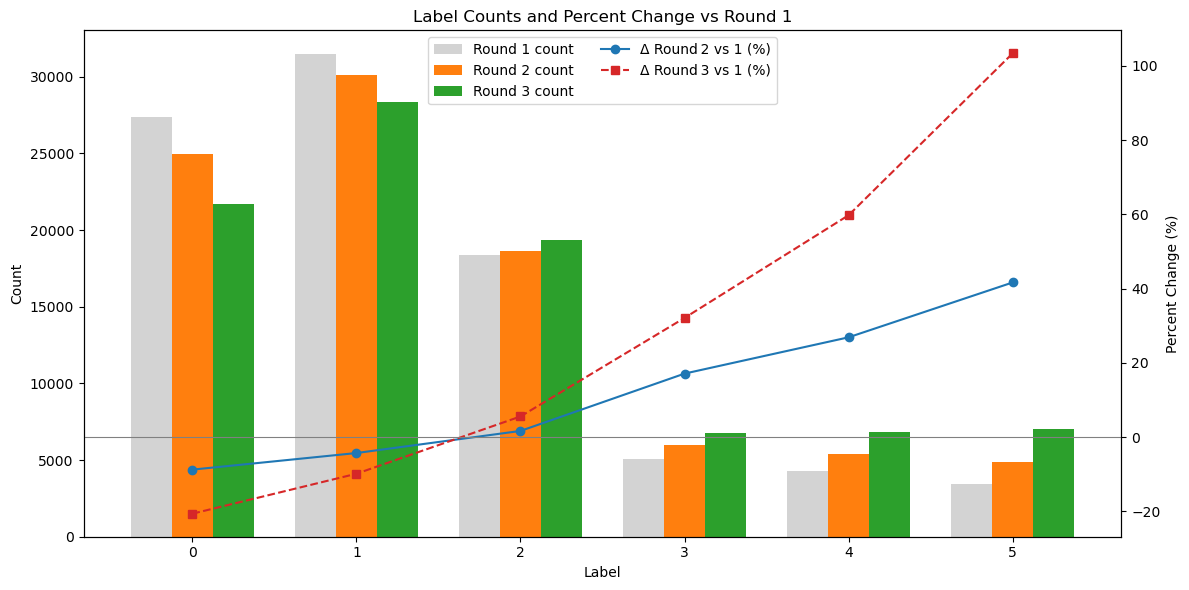

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths for each round’s interaction data
FIRST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
SECOND_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_cf.csv"
THIRD_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/third_round_interactions_5000_cf.csv"

# Load the data for each round
df1 = pd.read_csv(FIRST_PATH)
df2 = pd.read_csv(SECOND_PATH)
df3 = pd.read_csv(THIRD_PATH)

# Compute the label distribution for each round
dist1 = df1['label'].value_counts().sort_index()
dist2 = df2['label'].value_counts().sort_index()
dist3 = df3['label'].value_counts().sort_index()

# Combine into a single DataFrame, filling missing labels with 0
df_compare = pd.DataFrame({
    'Round 1': dist1,
    'Round 2': dist2,
    'Round 3': dist3
}).fillna(0).astype(int)

# compute percent change vs Round 1
pct2 = (df_compare['Round 2'] - df_compare['Round 1']) / df_compare['Round 1'] * 100
pct3 = (df_compare['Round 3'] - df_compare['Round 1']) / df_compare['Round 1'] * 100

labels = df_compare.index.astype(str).tolist()
x = np.arange(len(labels))
bar_w = 0.25

fig, ax1 = plt.subplots(figsize=(12, 6))

# draw the three bars side by side
ax1.bar(x - bar_w, df_compare['Round 1'], bar_w, label='Round 1 count', color='lightgray')
ax1.bar(x        , df_compare['Round 2'], bar_w, label='Round 2 count', color='C1')
ax1.bar(x + bar_w, df_compare['Round 3'], bar_w, label='Round 3 count', color='C2')

ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=0)

# second y‑axis for percent change
ax2 = ax1.twinx()
ax2.plot(x, pct2, marker='o', linestyle='-', color='tab:blue',  label='Δ Round 2 vs 1 (%)')
ax2.plot(x, pct3, marker='s', linestyle='--', color='tab:red', label='Δ Round 3 vs 1 (%)')
ax2.axhline(0, color='gray', linewidth=0.8)     # draw zero‑percent line
ax2.set_ylabel('Percent Change (%)')

# combine legends from both axes
bars, bar_labels = ax1.get_legend_handles_labels()
lines, line_labels = ax2.get_legend_handles_labels()
ax1.legend(bars + lines, bar_labels + line_labels,
           loc='upper center', ncol=2, frameon=True)

plt.title('Label Counts and Percent Change vs Round 1')
plt.tight_layout()
plt.show()


### Test Kaggle MovieLens Dataset with the same LambdaRank & Collaborative Filtering methods

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix

MOVIES_CSV  = "/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/movie.csv"
RATINGS_CSV = "/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/rating.csv"

movies  = pd.read_csv(MOVIES_CSV)
ratings = pd.read_csv(RATINGS_CSV)

ratings = ratings.sample(n=100_000, random_state=42).reset_index(drop=True)

ratings['rating2x'] = (ratings['rating'] * 2).round().astype(int)

FEATURES = ["total_ratings", "avg_rating", "cf_score"]
LABEL    = "rating2x"
GROUP    = "userId"
NDCG_AT  = [5, 10, 15]

fold_ndcg = {k: [] for k in NDCG_AT}
fold_map  = []

gkf = GroupKFold(n_splits=5)
for train_idx, val_idx in gkf.split(ratings, groups=ratings[GROUP]):
    tr = ratings.iloc[train_idx].copy()
    va = ratings.iloc[val_idx].copy()

    pop = tr.groupby("movieId").rating2x.agg(
        total_ratings="count",
        avg_rating="mean"
    ).reset_index()
    mv = movies.merge(pop, on="movieId", how="left")\
               .fillna({"total_ratings": 0, "avg_rating": 0})
    tr = tr.merge(mv[["movieId","total_ratings","avg_rating"]],
                  on="movieId", how="left")
    va = va.merge(mv[["movieId","total_ratings","avg_rating"]],
                  on="movieId", how="left")\
           .fillna({"total_ratings": 0, "avg_rating": 0})

    uids = tr[GROUP].unique()
    mids = tr["movieId"].unique()
    u2i  = {u:i for i,u in enumerate(uids)}
    m2i  = {m:i for i,m in enumerate(mids)}

    rows = tr[GROUP].map(u2i).to_numpy()
    cols = tr["movieId"].map(m2i).to_numpy()
    data = tr["rating2x"].to_numpy()
    R_tr = csr_matrix(coo_matrix((data, (rows, cols)),
                                 shape=(len(uids), len(mids))))

    knn = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
    knn.fit(R_tr)
    _, nbrs = knn.kneighbors(R_tr, return_distance=True)

    cf_dict = {}
    for ui, u in enumerate(uids):
        neighs = [uids[i] for i in nbrs[ui] if i != ui]
        sub = tr[tr[GROUP].isin(neighs)]
        cf_dict[u] = sub.groupby("movieId").rating2x.mean().to_dict()

    tr["cf_score"] = tr.apply(lambda r: cf_dict[r.userId].get(r.movieId, 0.0), axis=1)
    va["cf_score"] = va.apply(lambda r: cf_dict.get(r.userId, {}).get(r.movieId, 0.0), axis=1)

    dtr = lgb.Dataset(
        tr[FEATURES], label=tr[LABEL],
        group=tr.groupby(GROUP).size().tolist()
    )
    dva = lgb.Dataset(
        va[FEATURES], label=va[LABEL],
        group=va.groupby(GROUP).size().tolist(),
        reference=dtr
    )

    gain = [0, 1, 2, 3, 5, 8, 12, 18, 26, 36, 48]

    params = {
        "objective":     "lambdarank",
        "metric":        "ndcg",
        "ndcg_eval_at":  NDCG_AT,
        "label_gain":    gain,
        "learning_rate": 0.05,
        "num_leaves":    31,
        "min_data_in_leaf": 20,
        "verbose":       -1
    }

    model = lgb.train(
        params,
        dtr,
        valid_sets=[dva],
        num_boost_round=300,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(period=0)
        ]
    )

    va["pred"] = model.predict(va[FEATURES])

    for k in NDCG_AT:
        scores = []
        for _, grp in va.groupby(GROUP):
            y_true = grp[LABEL].values.reshape(1, -1)
            y_pred = grp["pred"].values.reshape(1, -1)
            if y_true.size > 1:
                scores.append(ndcg_score(y_true, y_pred, k=k))
        fold_ndcg[k].append(np.mean(scores))

    maps = []
    for _, grp in va.groupby(GROUP):
        y_bin = (grp[LABEL] == 10).astype(int)
        if y_bin.sum() > 0:
            maps.append(average_precision_score(y_bin, grp["pred"]))
    fold_map.append(np.mean(maps))

for k in NDCG_AT:
    print(f"CV NDCG@{k}: {np.mean(fold_ndcg[k]):.4f} ± {np.std(fold_ndcg[k]):.4f}")
print(f"CV MAP:    {np.mean(fold_map):.4f} ± {np.std(fold_map):.4f}")

pop = ratings.groupby("movieId").rating2x.agg(
    total_ratings="count",
    avg_rating="mean"
).reset_index()
mv  = movies.merge(pop, on="movieId", how="left")\
           .fillna({"total_ratings":0,"avg_rating":0})
ratings = ratings.merge(mv[["movieId","total_ratings","avg_rating"]],
                        on="movieId", how="left")

uids = ratings[GROUP].unique()
mids = ratings["movieId"].unique()
u2i  = {u:i for i,u in enumerate(uids)}
m2i  = {m:i for i,m in enumerate(mids)}

rows = ratings[GROUP].map(u2i).to_numpy()
cols = ratings["movieId"].map(m2i).to_numpy()
data = ratings["rating2x"].to_numpy()
R_all = csr_matrix(coo_matrix((data, (rows, cols)),
                              shape=(len(uids), len(mids))))

knn.fit(R_all)
_, nbrs = knn.kneighbors(R_all, return_distance=True)

cf_dict = {}
for ui, u in enumerate(uids):
    neighs = [uids[i] for i in nbrs[ui] if i != ui]
    sub    = ratings[ratings[GROUP].isin(neighs)]
    cf_dict[u] = sub.groupby("movieId").rating2x.mean().to_dict()

ratings["cf_score"] = ratings.apply(
    lambda r: cf_dict[r.userId].get(r.movieId, 0.0),
    axis=1
)

dall = lgb.Dataset(
    ratings[FEATURES], label=ratings[LABEL],
    group=ratings.groupby(GROUP).size().tolist()
)
final_model = lgb.train(
    params,
    dall,
    num_boost_round=model.best_iteration,
    callbacks=[lgb.log_evaluation(period=0)]
)
final_model.save_model(
    "/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/lambdarank_movielens100k.txt"
)


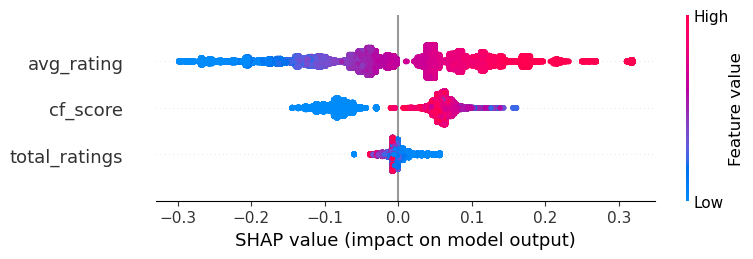

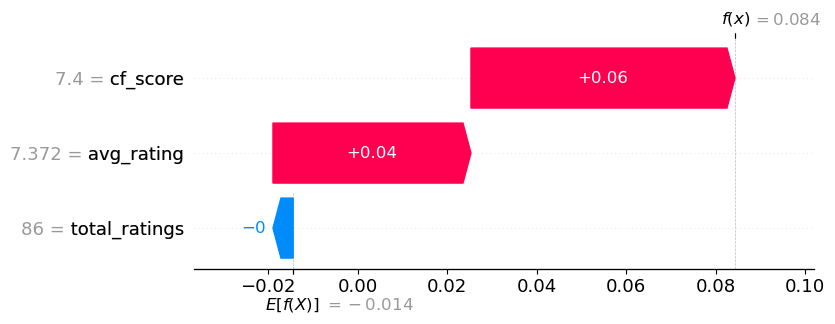

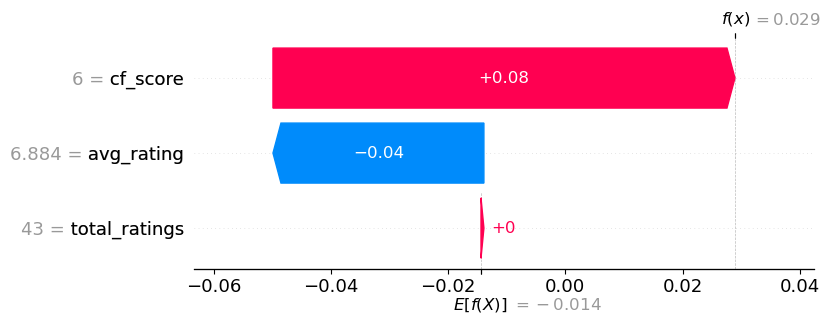

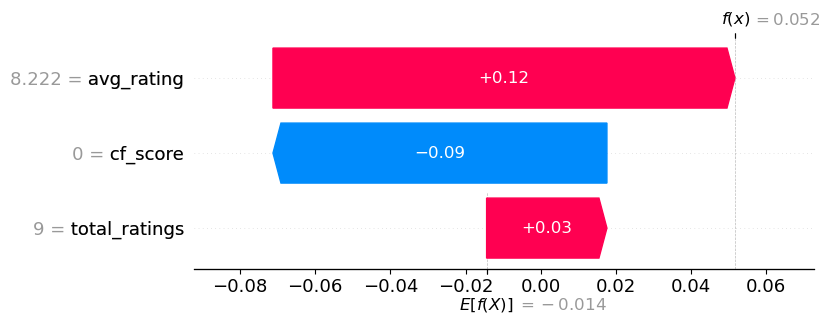

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.neighbors import NearestNeighbors

# load the trained model
model_path = "/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/lambdarank_movielens100k.txt"
ranker = lgb.Booster(model_file=model_path)

# read movies and ratings
movies = pd.read_csv("/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/movie.csv")
ratings = pd.read_csv("/Users/cailingchen/Desktop/Final Project/MovieLens Dataset/rating.csv")

# sample the same 100k used in training
ratings = ratings.sample(n=100_000, random_state=42).reset_index(drop=True)

# convert half‑step ratings to integers 1–10
ratings["rating2x"] = (ratings["rating"] * 2).round().astype(int)

# split out training pool (all sampled interactions)
train = ratings.copy()

# compute static features: total number of ratings and average rating per movie
pop = train.groupby("movieId").rating2x.agg(total_ratings="count", avg_rating="mean").reset_index()
movies = movies.merge(pop, on="movieId", how="left").fillna({"total_ratings": 0, "avg_rating": 0})

# compute collaborative filtering feature
uids = train["userId"].unique()
mids = train["movieId"].unique()
u2i  = {u: i for i, u in enumerate(uids)}
m2i  = {m: i for i, m in enumerate(mids)}

rows = train["userId"].map(u2i).to_numpy()
cols = train["movieId"].map(m2i).to_numpy()
data = train["rating2x"].to_numpy()
R = csr_matrix(coo_matrix((data, (rows, cols)), shape=(len(uids), len(mids))))

knn = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
knn.fit(R)
_, nbrs = knn.kneighbors(R, return_distance=True)

cf_dict = {}
for ui, u in enumerate(uids):
    neighs = [uids[i] for i in nbrs[ui] if i != ui]
    sub    = train[train["userId"].isin(neighs)]
    cf_dict[u] = sub.groupby("movieId").rating2x.mean().to_dict()

train["cf_score"] = train.apply(
    lambda r: cf_dict.get(r.userId, {}).get(r.movieId, 0.0), axis=1
)

# merge static movie features
train = train.merge(
    movies[["movieId", "total_ratings", "avg_rating"]],
    on="movieId", how="left"
)

# prepare the matrix for SHAP: only the three features
feature_cols = ["total_ratings", "avg_rating", "cf_score"]
X = train[feature_cols]

# create SHAP explainer and compute values
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X)

# global summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, feature_names=feature_cols, show=True)

# waterfall plots for three random users
for idx in np.random.choice(len(X), size=3, replace=False):
    plt.figure(figsize=(10, 4))
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value,
            data=X.iloc[idx],
            feature_names=feature_cols
        ),
        show=True
    )
